In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import joblib

from cts_recommender.settings import get_settings
from cts_recommender.logging_setup import setup_logging
from cts_recommender.io import readers
from cts_recommender.environments.TV_environment import TVProgrammingEnvironment
from cts_recommender.models.audience_regression.audience_ratings_regressor import AudienceRatingsRegressor
from cts_recommender.models.curator_logistic_regressor import load_curator_model
from cts_recommender.models.contextual_thompson_sampler import ContextualThompsonSampler
from cts_recommender.imitation_learning.IL_constants import PSEUDO_REWARD_WEIGHTS
from cts_recommender.utils.visualization import (
    extract_reward_signals, 
    print_reward_statistics,
    plot_reward_distributions,
    visualize_cts_signal_weight_distributions,
    plot_cts_training_history,
    print_cts_training_summary
)

cfg = get_settings()
setup_logging("INFO")
logger = logging.getLogger(__name__)

## Open Data and Load environment

In [70]:
# Load data
catalog_df = readers.read_parquet(cfg.processed_dir / "whatson" / "whatson_catalog.parquet")
historical_programming_df = readers.read_parquet(cfg.processed_dir / "programming" / "historical_programming.parquet")
audience_model = AudienceRatingsRegressor()
audience_model.load_model(cfg.models_dir / "audience_ratings_model.joblib")

# Initialize environment
env = TVProgrammingEnvironment(catalog_df, historical_programming_df, audience_model)

# Load training samples and data
training_samples = joblib.load(cfg.processed_dir / "IL" / "training_samples.joblib")
training_data = joblib.load(cfg.processed_dir / "IL" / "training_data.joblib")
curator_model = load_curator_model("data/models/curator_logistic_model.joblib")

print(f"Loaded {len(training_samples)} training samples")

2025-10-22 16:35:34 INFO cts_recommender.models.audience_regression.audience_ratings_regressor: Model loaded from data/models/audience_ratings_model.joblib with 71 features
2025-10-22 16:35:34 INFO cts_recommender.environments.TV_environment: Setting up CompetitorDataManager...
2025-10-22 16:35:34 INFO cts_recommender.environments.TV_environment: Setting up Scalers...
2025-10-22 16:35:34 INFO cts_recommender.environments.TV_environment: Setting up RewardCalculator...
2025-10-22 16:35:34 INFO cts_recommender.environments.reward: RewardCalculator initialized successfully.
2025-10-22 16:35:35 INFO cts_recommender.models.curator_logistic_regressor: Loading curator model from data/models/curator_logistic_model.joblib
2025-10-22 16:35:35 INFO cts_recommender.models.curator_logistic_regressor: Curator model loaded successfully


Loaded 7206 training samples


## Visualize Reward Signal Distributions

In [1]:
# Analyze reward signals
signals = extract_reward_signals(training_samples)
print_reward_statistics(signals)

NameError: name 'extract_reward_signals' is not defined

## Signal Correlation Analysis

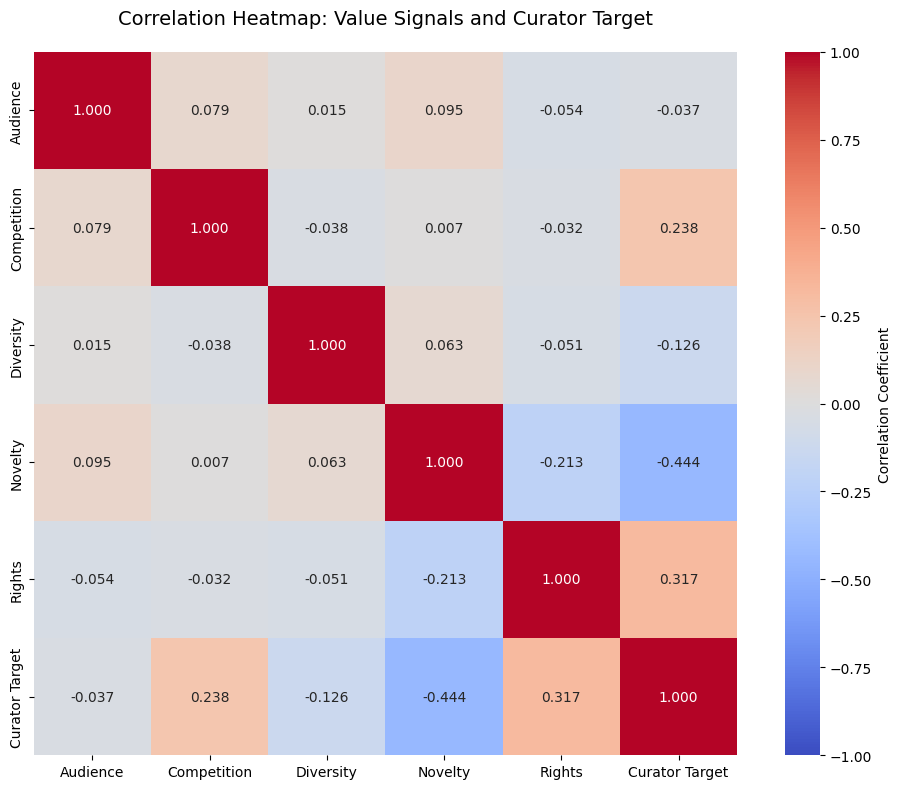


Key Correlations with Curator Target:
  Audience       : -0.037
  Competition    :  0.238
  Diversity      : -0.126
  Novelty        : -0.444
  Rights         :  0.317


In [72]:
# Signal correlation analysis
signal_names = ['Audience', 'Competition', 'Diversity', 'Novelty', 'Rights', 'Curator Target']

data_matrix = []
for sample in training_samples:
    vs = sample['value_signals']
    row = [vs['audience'], vs['competition'], vs['diversity'], vs['novelty'], vs['rights'], float(sample['selected'])]
    data_matrix.append(row)

corr_matrix = np.corrcoef(np.array(data_matrix).T)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True,
            xticklabels=signal_names, yticklabels=signal_names, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'}, ax=ax)
plt.title('Correlation Heatmap: Value Signals and Curator Target', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nKey Correlations with Curator Target:")
for i, name in enumerate(signal_names[:-1]):
    print(f"  {name:15s}: {corr_matrix[i, -1]:6.3f}")

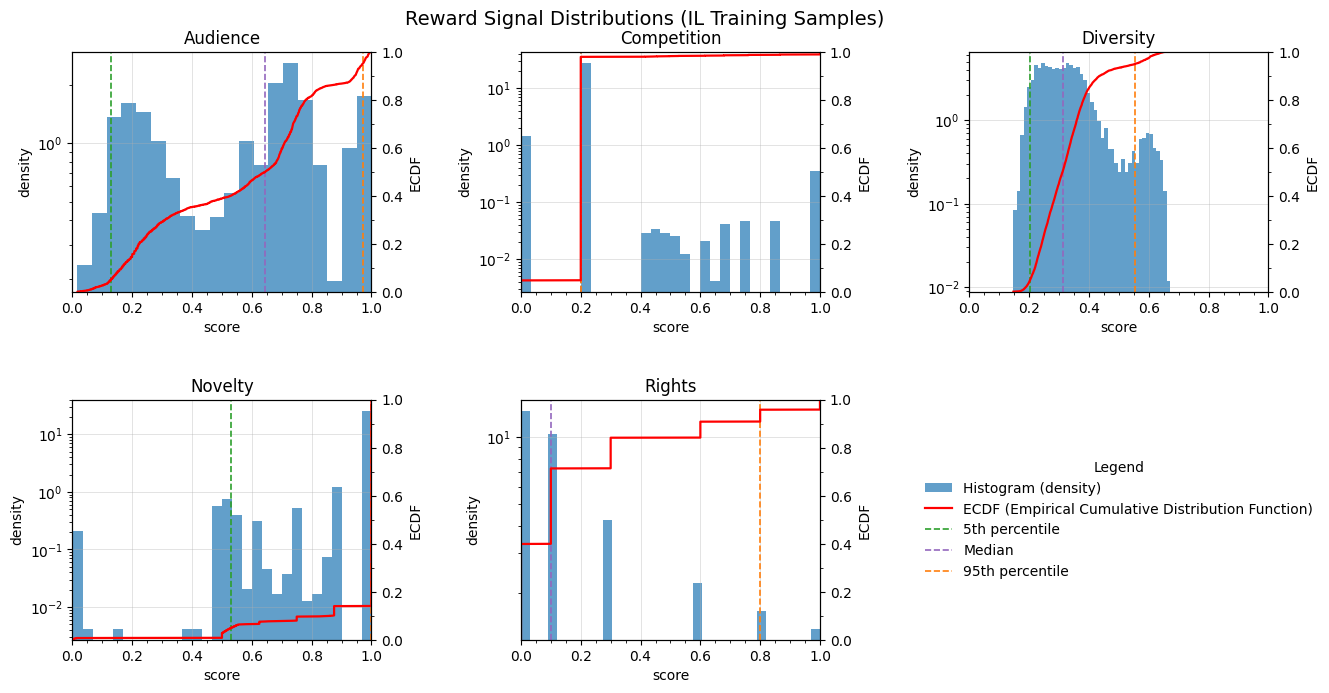

In [73]:
# Reward signal distributions
signals_display = {
    "Audience": signals['audience'],
    "Competition": signals['competition'],
    "Diversity": signals['diversity'],
    "Novelty": signals['novelty'],
    "Rights": signals['rights'],
}

fig, axes = plot_reward_distributions(signals_display, title="Reward Signal Distributions (IL Training Samples)")
plt.show()

## Prepare CTS Training Data

In [74]:
# Combine training and validation data for CTS
context_features = np.concatenate((training_data['train']['context_features'], training_data['val']['context_features']))
movie_features = np.concatenate((training_data['train']['movie_features'], training_data['val']['movie_features']))
rewards = np.concatenate((training_data['train']['reward_targets'], training_data['val']['reward_targets']))

context_dim = context_features.shape[1]
movie_dim = movie_features.shape[1]

# Extract signal matrix (6 signals: audience, competition, diversity, novelty, rights, curator_acceptance)
def extract_signal_matrix_from_samples(samples):
    signal_list = []
    for sample in samples:
        vs = sample['value_signals']
        signals = [vs['audience'], vs['competition'], vs['diversity'], vs['novelty'], vs['rights'], float(sample['selected'])]
        signal_list.append(signals)
    return np.array(signal_list)

train_signals = extract_signal_matrix_from_samples(training_samples)
num_signals = train_signals.shape[1]

logger.info(f"Context dim: {context_dim}, Movie dim: {movie_dim}, Signals: {num_signals}, Samples: {len(context_features)}")

2025-10-22 16:35:38 INFO __main__: Context dim: 18, Movie dim: 24, Signals: 6, Samples: 7206


In [75]:
# For CTS, we need 6 signals:
# 1-5: audience, competition, diversity, novelty, rights (from value_signals)
# 6: curator_acceptance (binary 1/0 for offline warm-start, probability from logistic model for online learning)

# Extract signal values from training samples and construct signal matrix
def extract_signal_matrix_from_samples(samples):
    """
    Extract 6-dimensional signal vectors from training samples.
    
    Returns:
        signal_matrix: (n_samples, 6) array with [audience, competition, diversity, novelty, rights, curator_acceptance]
    """
    signal_list = []
    for sample in samples:
        # Get the 5 value signals
        value_signals = sample['value_signals']
        signals = [
            value_signals['audience'],
            value_signals['competition'],
            value_signals['diversity'],
            value_signals['novelty'],
            value_signals['rights'],
            float(sample['selected'])  # Curator acceptance (1 if selected, 0 if not)
        ]
        signal_list.append(signals)
    return np.array(signal_list)

# Extract signal matrices for train and val
train_signals = extract_signal_matrix_from_samples([s for s in training_samples])

# Number of signals (6: audience, competition, diversity, novelty, rights, curator_acceptance)
num_signals = train_signals.shape[1]

logger.info(f"Signal matrix shape: {train_signals.shape}")
logger.info(f"Signal ordering: [audience, competition, diversity, novelty, rights, curator_acceptance]")

2025-10-22 16:35:38 INFO __main__: Signal matrix shape: (7206, 6)
2025-10-22 16:35:38 INFO __main__: Signal ordering: [audience, competition, diversity, novelty, rights, curator_acceptance]


## Initialize and Configure CTS

In [76]:
# Initialize Contextual Thompson Sampler
cts = ContextualThompsonSampler(
    num_signals=num_signals,
    context_dim=context_dim,
    lr=0.05,
    expl_scale=0.001,
    ema_decay=0.999,
    h0=1e-1,
    tau=2.0,
    alpha=0.3,
    weight_decay=1e-4,
    match_loss_weight=0.5,
    random_state=cfg.random_seed
)

logger.info(f"Initialized CTS with {num_signals} signals and {context_dim} context features")

2025-10-22 16:35:38 INFO __main__: Initialized CTS with 6 signals and 18 context features


### Initialize with IL-Based Target Weights

In [77]:
# Initialize CTS with IL-based target weights
signal_names_short = ['Audience', 'Competition', 'Diversity', 'Novelty', 'Rights', 'Curator']

pseudo_weights = np.array([
    PSEUDO_REWARD_WEIGHTS['audience'],
    PSEUDO_REWARD_WEIGHTS['competition'],
    PSEUDO_REWARD_WEIGHTS['diversity'],
    PSEUDO_REWARD_WEIGHTS['novelty'],
    PSEUDO_REWARD_WEIGHTS['rights']
])

gamma = 0.3  # Match IL training gamma
target_weights = np.zeros(num_signals)
target_weights[:5] = (1 - gamma) * pseudo_weights
target_weights[5] = gamma

logger.info("Initializing CTS with IL-based target weights (gamma=0.3):")
for i, name in enumerate(signal_names_short):
    logger.info(f"  {name:12s}: {target_weights[i]:.4f}")

cts.initialize_with_target_weights(target_weights)

2025-10-22 16:35:38 INFO __main__: Initializing CTS with IL-based target weights (gamma=0.3):
2025-10-22 16:35:38 INFO __main__:   Audience    : 0.2800
2025-10-22 16:35:38 INFO __main__:   Competition : 0.1050
2025-10-22 16:35:38 INFO __main__:   Diversity   : 0.0700
2025-10-22 16:35:38 INFO __main__:   Novelty     : 0.1400
2025-10-22 16:35:38 INFO __main__:   Rights      : 0.1050
2025-10-22 16:35:38 INFO __main__:   Curator     : 0.3000


### CTS Signal Weights (Before Training)

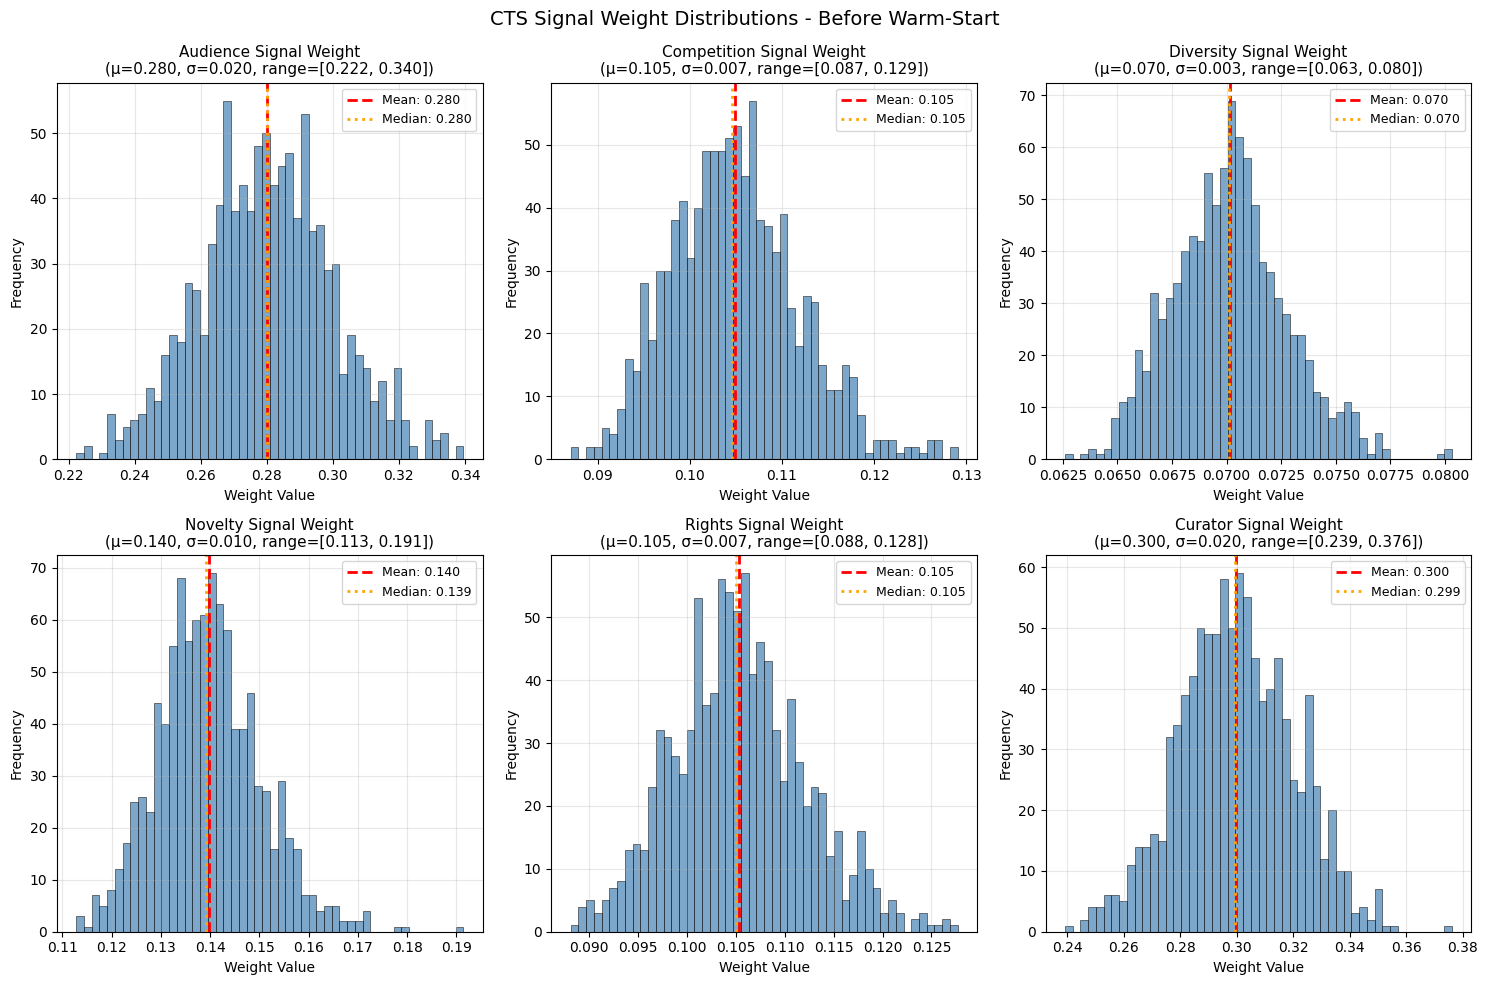

In [78]:
# Visualize initial weights before warm-start
fig, axes = visualize_cts_signal_weight_distributions(cts_model=cts, env=env)
plt.suptitle('CTS Signal Weight Distributions - Before Warm-Start', fontsize=14, y=0.98)
plt.show()

## Warm-Start Training

In [79]:
# Warm-start training
epochs = 1
lr = 1e-2
expl_scale = 1e-4
ema_decay = 0.9999
monitor_every = 500

logger.info(f"Training for {epochs} epochs with lr={lr}, ema_decay={ema_decay}")

history = cts.warm_start(
    contexts=context_features,
    signals=train_signals,
    rewards=rewards,
    epochs=epochs,
    lr=lr,
    expl_scale=expl_scale,
    ema_decay=ema_decay,
    monitor_every=monitor_every,
    weight_decay=cts.weight_decay,
    verbose=True
)

print_cts_training_summary(history)

2025-10-22 16:35:41 INFO __main__: Training for 1 epochs with lr=0.01, ema_decay=0.9999


Epoch 1/1: avg_loss=0.056507, |U|=1.6381, |b|=4.6678, h_U_median=0.048645
CTS WARM-START TRAINING SUMMARY

Training Progress:
  Total updates: 7,000
  Epochs completed: 0.97
  Monitoring points: 14

Parameter Evolution:
  ||U|| : 0.124162 → 1.597650 (change: +1.473487)
  ||b|| : 4.313893 → 4.654009 (change: +0.340117)
  max|U|: 0.062305 → 0.872056
  max|b|: 2.831313 → 3.076245

Curvature (h_U) Evolution:
  Initial h_U (h0): 0.095123
  Final h_U mean:   0.049663 (↓ 47.8%)
  Final h_U median: 0.049658
  Final h_U range:  [0.049657, 0.049741]

Gradient Statistics (final epoch):
  ||grad_U||: 0.031579
  ||grad_b||: 0.015611
  max|grad_U|: 0.012428
  max|grad_b|: 0.012136

Noise Levels:
  Initial noise_std(U): 0.032423
  Final noise_std(U):   0.044873

Signal-to-Noise Ratio:
  Final SNR: 9.52 ✅ (target: ≥3.0)

Training Loss:
  Initial: 0.013452
  Final:   0.068171
  Reduction: -406.8%


## Training Dynamics Visualization

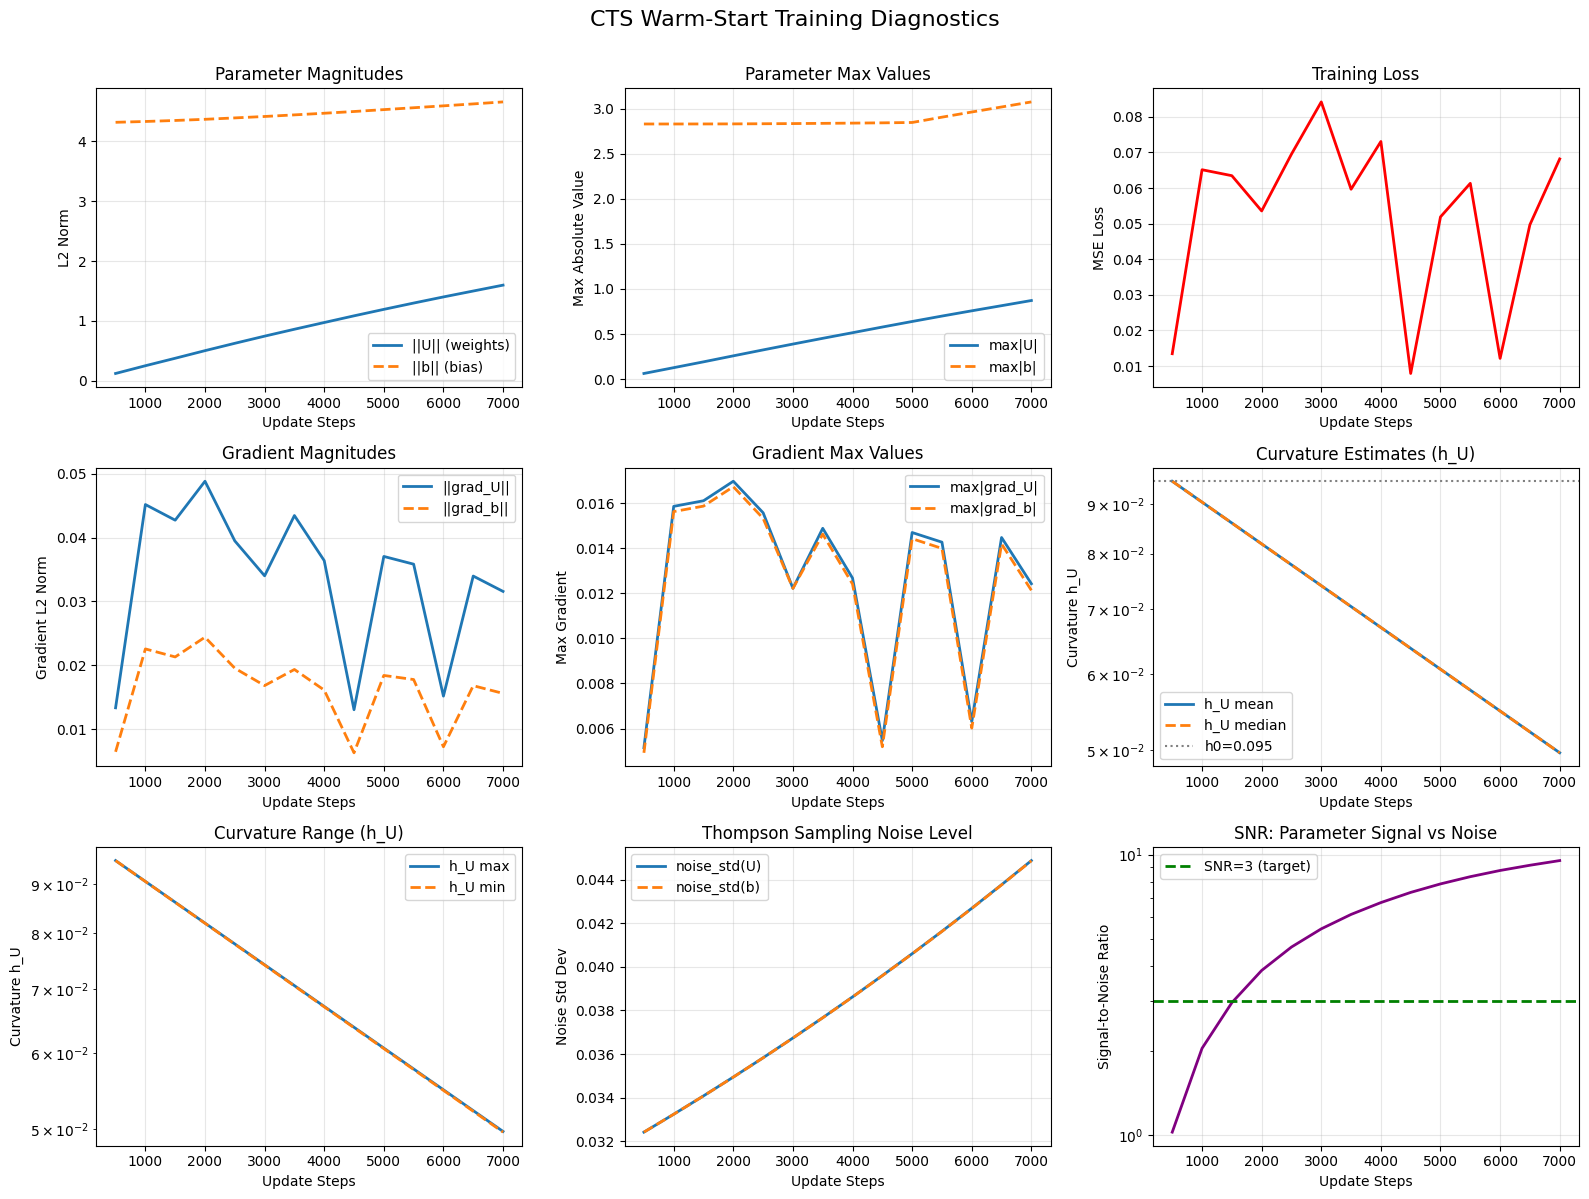

In [80]:
# Comprehensive training metrics dashboard
fig, axes = plot_cts_training_history(history)
plt.show()

## CTS Signal Weights (After Training)

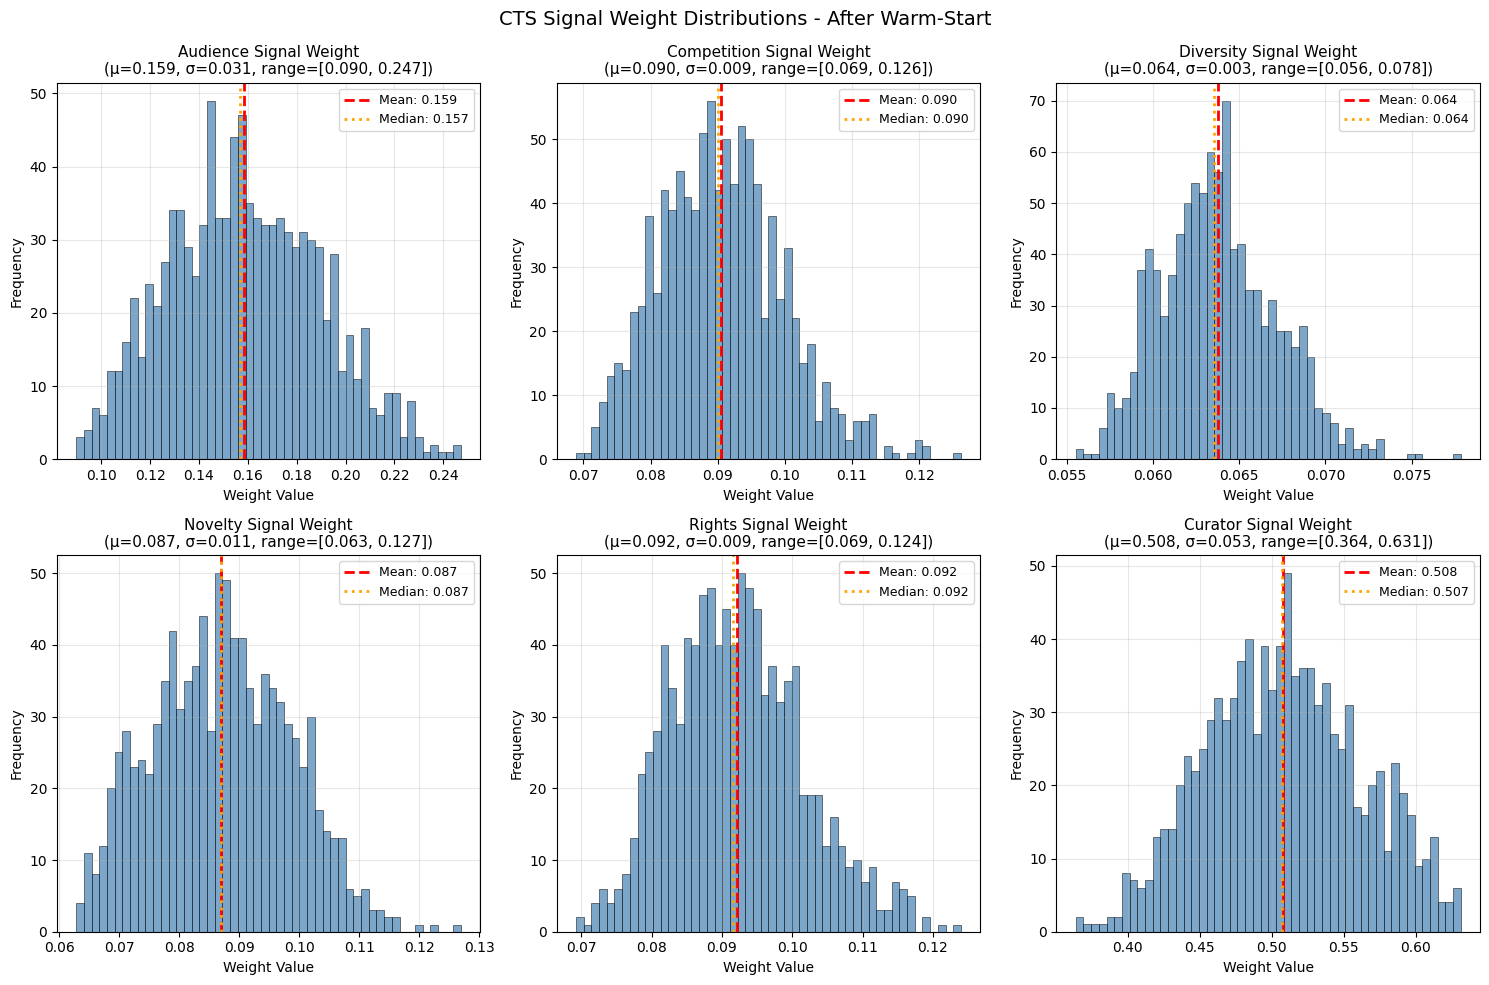

In [81]:
# Visualize learned weights after warm-start
fig, axes = visualize_cts_signal_weight_distributions(cts_model=cts, env=env)
plt.suptitle('CTS Signal Weight Distributions - After Warm-Start', fontsize=14, y=0.98)
plt.show()